2017-07-06 12:24:02.731000
Now plotting errors
Array saved to disk


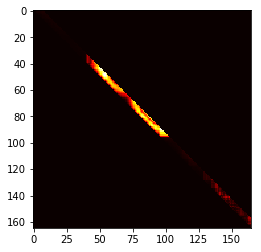

Plot Saved to Disk
2017-07-06 12:31:08.391000
Now Plotting Errors
Array saved to disk


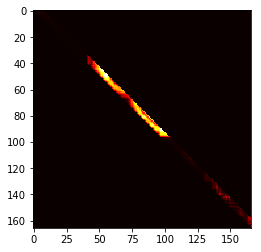

Plot Saved to Disk
2017-07-06 12:37:50.343000


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import similaritymetrics as ims
import datetime

def plotError(frameCount, extraDiag):
    print "Now plotting errors"
    #Create our array of zeros as a 2D numpy array
    errors = np.zeros((frameCount, frameCount))
    #Now Populate our 2 Diagonal Errors
    #Current structure allows image1 loaded once and reused
    for i in range(0, frameCount-1):
        image1 = cv2.imread("frame%0*d.png" %(4,i+1))
        image2 = cv2.imread("frame%0*d.png" %(4,i+2))
        #First Diagonal is y=x+1
        errors[i, i+1]=ims.dssimCompare(image1, image2)
        #Second Diagonal is y=x+2
        #This loop calls our extra diagonals for however many we specify
        #We need to add guarding here to prevent looking for an image that extends beyond available frames
        for j in range(0, extraDiag):
            image2 = cv2.imread("frame%0*d.png" %(4,i+3+j))
            #null pointer type exception
            if(image2 is None):
                continue
            errors[i, i+2+j]=ims.dssimCompare(image1, image2)    
    #Save our array
    np.savetxt('array.txt', errors)
    print "Array saved to disk"
    #Now plot and we need a way to save our plot
    plt.imshow(errors, cmap='hot', interpolation='nearest')
    plt.show()
    plt.savefig("errorplot.png")
    print "Plot Saved to Disk"
    
def plotErrorDict(frameCount, extraDiag):
    print "Now Plotting Errors"
    errors = np.zeros((frameCount+1, frameCount+1))
    #Create Dictionary with initial items
    imagedict = {}
    for i in range(1, frameCount):
        #Add Entries to Dictionary, only add a single entry when i>1
        if(i>1):
            imagedict["{0}".format(i+extraDiag+1)]= cv2.imread("frame%0*d.png" %(4,i+extraDiag+1))
        else:
            for j in range(i, extraDiag+3):   
                imagedict["{0}".format(j)]= cv2.imread("frame%0*d.png" %(4,j))
        #Then Compare
        for k in range(i+1, i+extraDiag+2):
            if(imagedict["%d" %(k)] is None):
                continue
            errors[i,k] = ims.dssimCompare(imagedict["%d" %(i)],imagedict["%d" %(k)])
        #Then delete as needed, we'll delete the earliest created entry
        del imagedict["%d" %(i)]
    np.savetxt('array.txt', errors)
    print "Array saved to disk"
    #Now plot and we need a way to save our plot
    plt.imshow(errors, cmap='hot', interpolation='nearest')
    plt.show()
    plt.savefig("errorplot.png")
    print "Plot Saved to Disk"
    
    
#optimum path
def framePath():
    #First Load Array
    np.loadtext('array.txt', errors)
    print 'Array Loaded'
    #Now find our best route through it
    #More to come
    #https://www.codechef.com/wiki/tutorial-dynamic-programming

#Main Function
#By this unscientific timing the first algo takes 24 seconds and the dictionary based approach is 16 seconds. So roughly 33% quicker
#Repeated with dSSIM we have 7min 6sec and 6min 42 sec. Likely due to the fact that the increase is due to dSSIM being more costly
int datetime.datetime.utcnow()
plotError(165, 6)
print datetime.datetime.utcnow()
plotErrorDict(165, 6)
print datetime.datetime.utcnow()
